# Band Ratios Plot

This plot compares different ways to get the exact same result in terms of the difference in BandRatios between two power spectra. 

As an example case, it uses the theta-beta ratio. 

Numerically identically delta th/be ratio can be obtained from:
- a change in theta power
- a change in beta power
- a change in theta bandwidth
- a change in beta bandwidth
- a change in beta center frequency
- a change in slope

Note that for a given change (or direction of change) in TBR, there is only one CF change that could do it, in the case in which the 'baseline' PSD has oscillations entirely within band ranges. In this example, the change is a relative increase in 'theta', and there is no way to increase relative theta with CF alone, given the comparison point - but this is just inherent in the choice of comparison PSD. 

In practice, all of these changes could happen together. 

Conclusion / problem statement: given an observed change in a BandRatio measure, there is no way to tell what has actually changed. There is no reason to think the change even reflects oscillatory activity, given that aperiodic shifts can drive this effect. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF
from fooof.synth import gen_power_spectrum
from fooof.plts.spectra import plot_spectrum, plot_spectra, plot_spectrum_shading, plot_spectra_shading

In [2]:
# Add band ratios code
import sys
sys.path.append('/Users/tom/Documents/GitCode/BandRatios/')
from utils.ratios import calc_band_ratio

In [3]:
# Band Settings
theta_band = [4, 8]
beta_band = [20, 30]

In [4]:
# Synthetic PSD settings
freq_range = [1, 40]
freq_res = 0.1
nlv = 0

base_ap = [0, 1.5]
base_theta = [6, 0.4, 1]
base_beta  = [25, 0.3, 2]

In [5]:
# Create the baseline PSD, to compare to
fs, ps_base = gen_power_spectrum(freq_range, base_ap, [base_theta, base_beta], nlv=nlv, freq_res=freq_res)

# Changes in oscillation power
fs, ps_th_in = gen_power_spectrum(freq_range, base_ap, [[6, 0.557, 1], base_beta], nlv=nlv, freq_res=freq_res)
fs, ps_be_de = gen_power_spectrum(freq_range, base_ap, [base_theta, [25, 0.106, 2]], nlv=nlv, freq_res=freq_res)

# Changes in oscillation bandwidth
fs, ps_th_bw = gen_power_spectrum(freq_range, base_ap, [[6, 0.4, 2.21], base_beta], nlv=nlv, freq_res=freq_res)
fs, ps_be_bw = gen_power_spectrum(freq_range, base_ap, [base_theta, [25, 0.3, 0.594]], nlv=nlv, freq_res=freq_res)

# Change in center frequency
fs, ps_be_cf = gen_power_spectrum(freq_range, base_ap, [base_theta, [18.595, 0.3, 2]], nlv=nlv, freq_res=freq_res)

# Change in aperiodic slope (note: due to current fooof.synth, this also alters offset, to change rotation point)
fs, ps_ap_sl = gen_power_spectrum(freq_range, [0.2, 1.6635], [base_theta, base_beta], nlv=nlv, freq_res=freq_res)

In [6]:
# Calcualte th/be ratio of the baseline PSD
base_br = calc_band_ratio(fs, ps_base, theta_band, beta_band)

In [7]:
# Calculate delta TBRs
d_th_in = base_br - calc_band_ratio(fs, ps_th_in, theta_band, beta_band)
d_be_de = base_br - calc_band_ratio(fs, ps_be_de, theta_band, beta_band)

d_th_bw = base_br - calc_band_ratio(fs, ps_th_bw, theta_band, beta_band)
d_be_bw = base_br - calc_band_ratio(fs, ps_be_bw, theta_band, beta_band)

d_be_cf = base_br - calc_band_ratio(fs, ps_be_cf, theta_band, beta_band)

d_ap_sl = base_br - calc_band_ratio(fs, ps_ap_sl, theta_band, beta_band)

In [8]:
# Check TBR difference measures
for diff, label in zip([d_th_in, d_be_de, d_th_bw, d_be_bw, d_be_cf, d_ap_sl],
                       ['Th-Amp', 'Be-Amp', 'Th-Bw', 'Be-Bw', 'Be-CF', 'AP-Sl']):
    print('TBR difference from   {}   is \t{:1.3f}'.format(label, diff))

TBR difference from   Th-Amp   is 	-3.007
TBR difference from   Be-Amp   is 	-3.001
TBR difference from   Th-Bw   is 	-3.003
TBR difference from   Be-Bw   is 	-3.000
TBR difference from   Be-CF   is 	-3.005
TBR difference from   AP-Sl   is 	-3.007


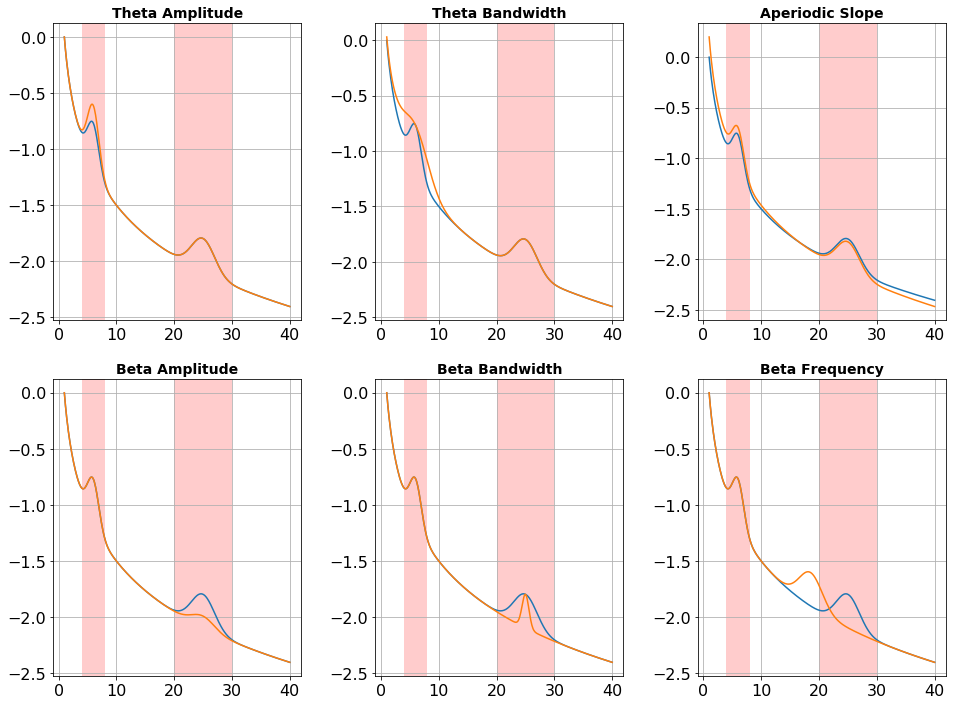

In [9]:
# Create figure
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

plot_spectra_shading(fs, [ps_base, ps_th_in], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax[0, 0])
plot_spectra_shading(fs, [ps_base, ps_be_de], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax[1, 0])
plot_spectra_shading(fs, [ps_base, ps_th_bw], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax[0, 1])
plot_spectra_shading(fs, [ps_base, ps_be_bw], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax[1, 1])
plot_spectra_shading(fs, [ps_base, ps_ap_sl], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax[0, 2])
plot_spectra_shading(fs, [ps_base, ps_be_cf], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax[1, 2])

title_settings = {'fontsize': 14, 'fontweight': 'bold'}
ax[0, 0].set_title('Theta Amplitude', **title_settings);
ax[1, 0].set_title('Beta Amplitude', **title_settings);
ax[0, 1].set_title('Theta Bandwidth', **title_settings);
ax[1, 1].set_title('Beta Bandwidth', **title_settings);
ax[0, 2].set_title('Aperiodic Slope', **title_settings);
ax[1, 2].set_title('Beta Frequency', **title_settings);

# Drop axis labels 
for aa in ax.reshape(-1): 
    aa.xaxis.label.set_visible(False)
    aa.yaxis.label.set_visible(False)

fig.subplots_adjust(hspace=.2)
fig.subplots_adjust(wspace=.3)

plt.savefig('BandRatiosMessiness.png')

## But it gets worse!

Oscillations need not apply.

In [10]:
fs, ps_new_base = gen_power_spectrum(freq_range, base_ap, [], nlv=nlv, freq_res=freq_res)
fs, ps_new_apch = gen_power_spectrum(freq_range, [0.2, 1.693], [], nlv=nlv, freq_res=freq_res)

In [11]:
d_th_in = calc_band_ratio(fs, ps_new_base, theta_band, beta_band) - \
          calc_band_ratio(fs, ps_new_apch, theta_band, beta_band)
print(d_th_in)

-3.0023449117779126


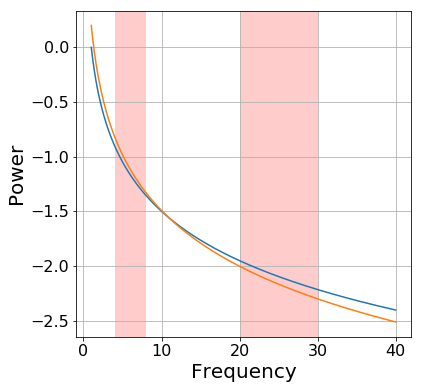

In [12]:
fig = plt.figure(figsize=[6, 6])
ax = plt.gca()
plot_spectra_shading(fs, [ps_new_base, ps_new_apch], [theta_band, beta_band], log_freqs=False, log_powers=True, ax=ax)

There needn't be any oscillations present at all, but merely a mild slope difference.